In [14]:
#!/usr/bin/env python

from __future__ import division, print_function

import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
is_done = False


# Load the gym environment
env = gym.make('Snake-8x8-v0')
env.reset()
env.seed(99)
PATH = 'models/snakeai0.pkl'
model = torch.load(PATH)

/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/home/malthet/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


In [15]:
resize = T.Compose([T.ToPILImage(),
                    #T.Grayscale(),
                    T.Resize(40, interpolation=Image.BOX),
                    T.ToTensor()])

def select_action(state):
    return model(state).max(1)[1].view(1, 1)

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


/home/malthet/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


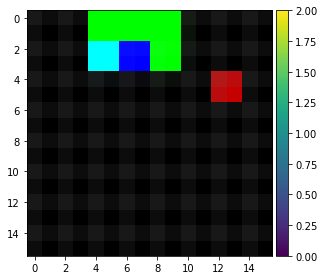

In [19]:
from skimage import io

last_screen = get_screen()
env.step(1)
current_screen = get_screen()
img = current_screen + last_screen

io.imshow(img.squeeze(0).numpy().transpose(2, 1, 0))
